
=== Total Consumption Statistics ===
count    3.400000e+01
mean     3.256253e+06
std      4.474216e+05
min      2.495402e+06
25%      2.825712e+06
50%      3.408844e+06
75%      3.588204e+06
max      3.917123e+06
Name: total_consumption, dtype: float64


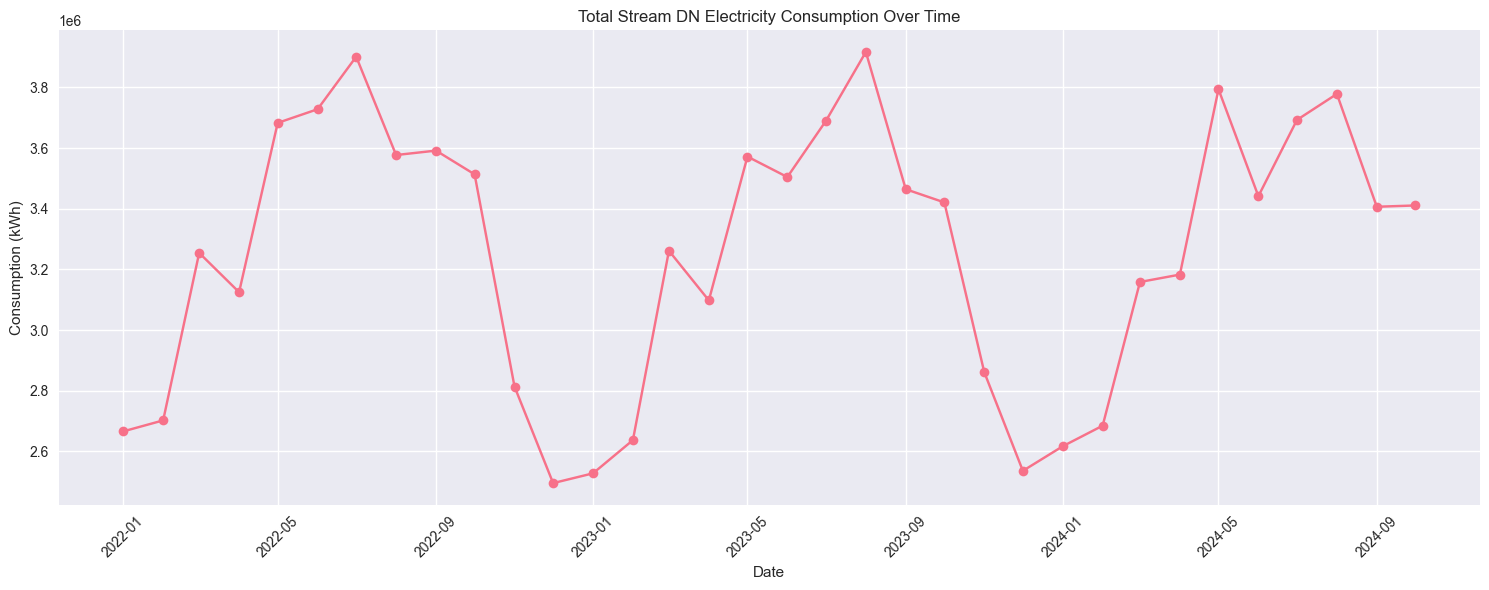

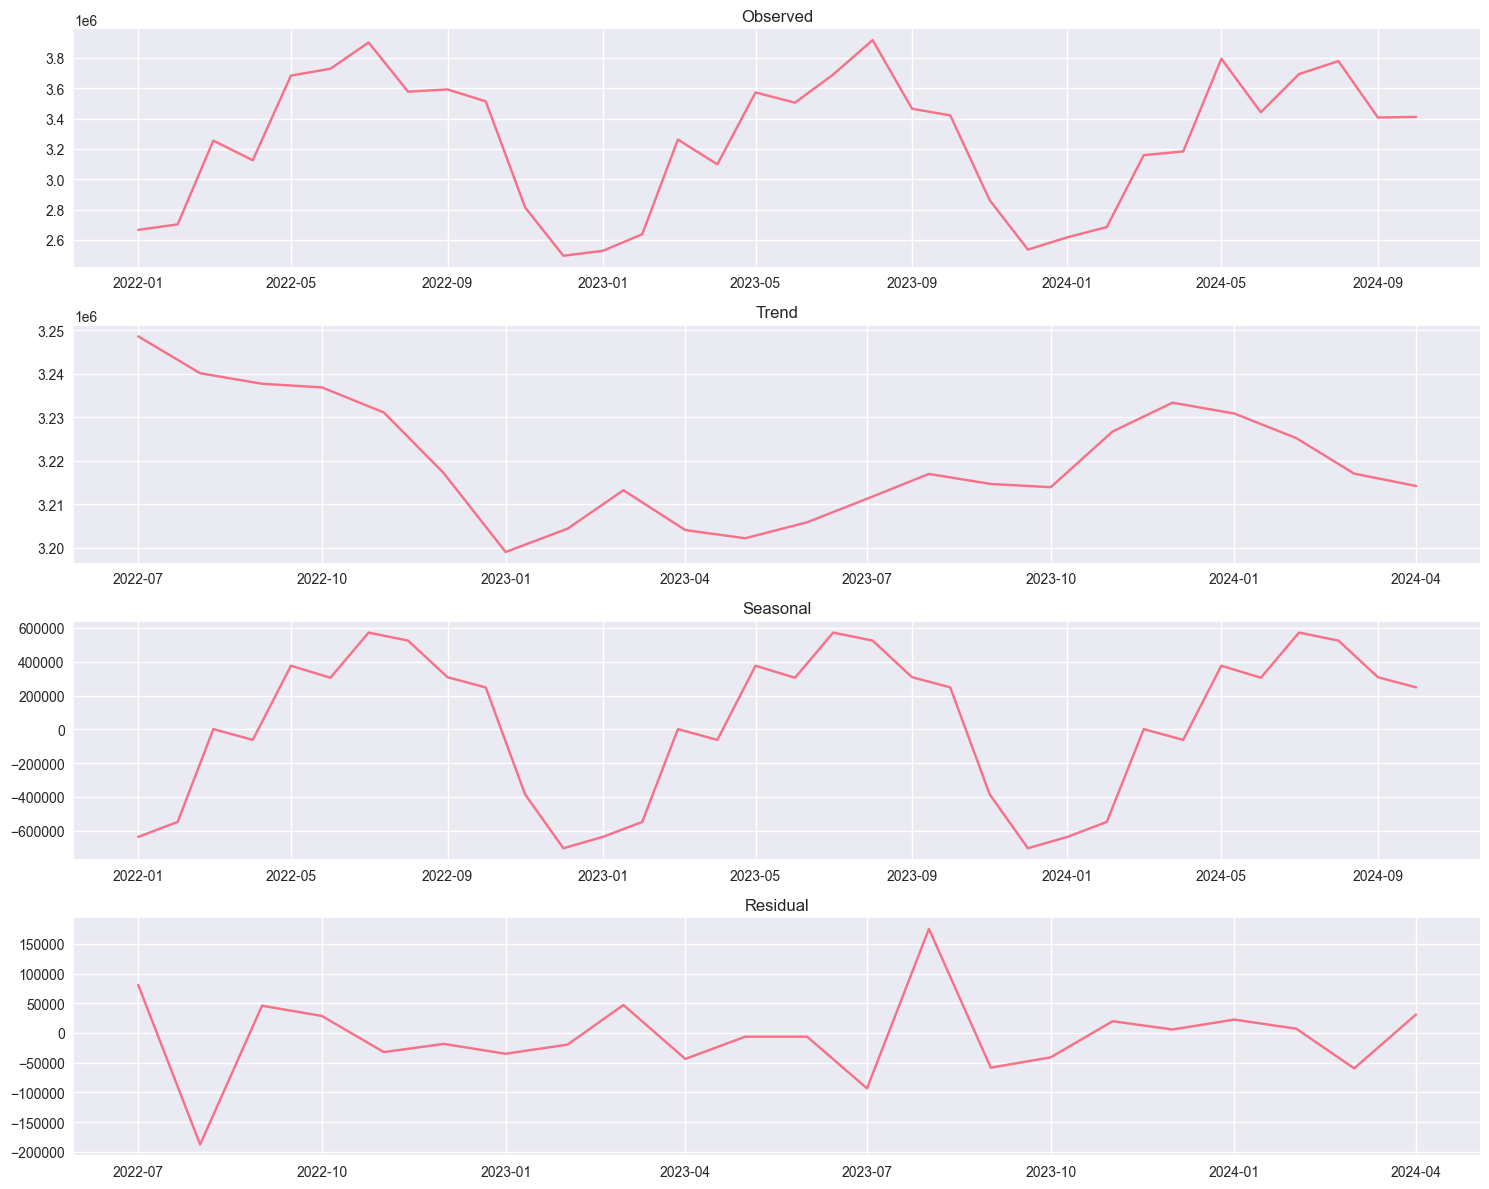

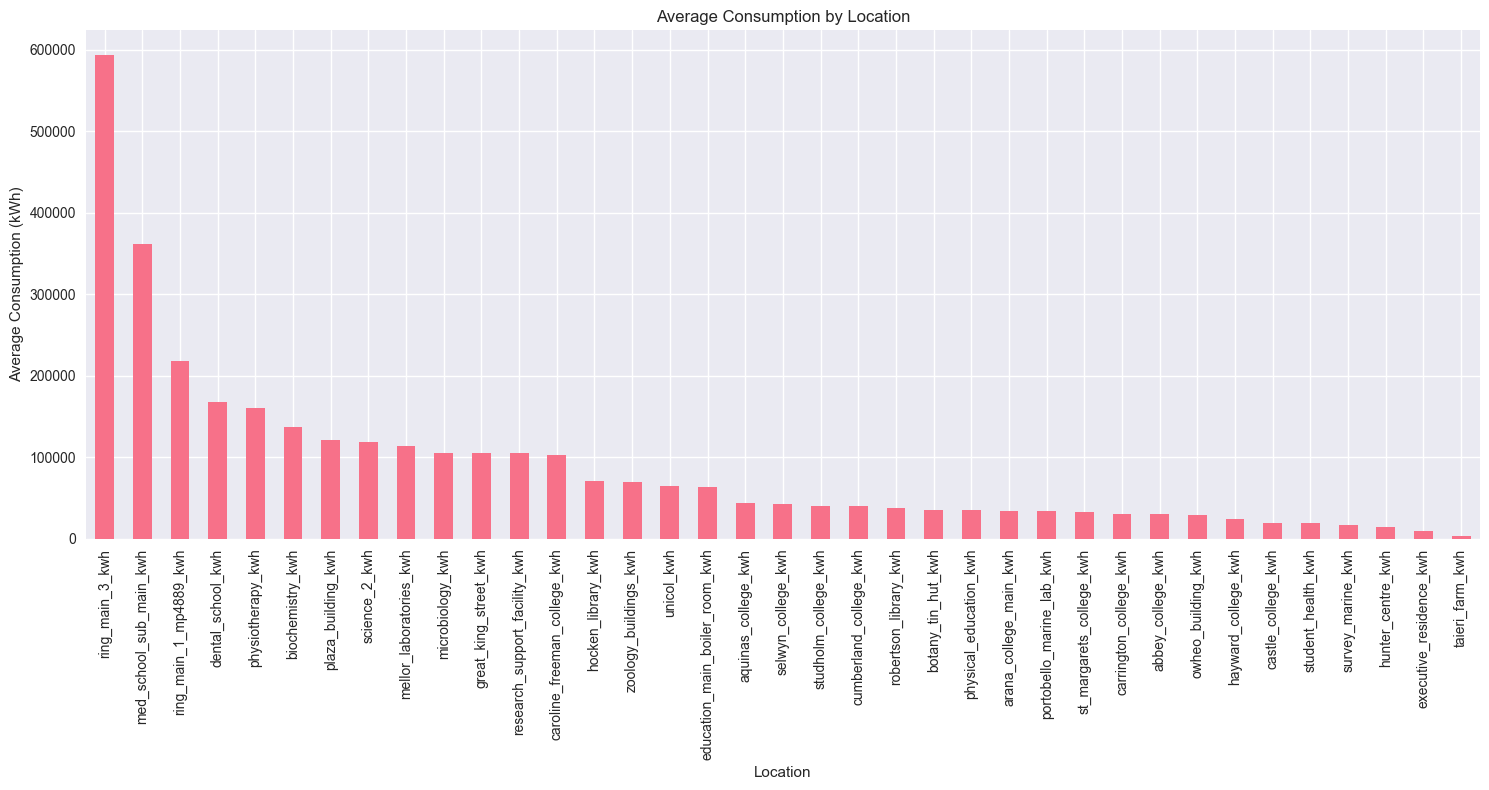

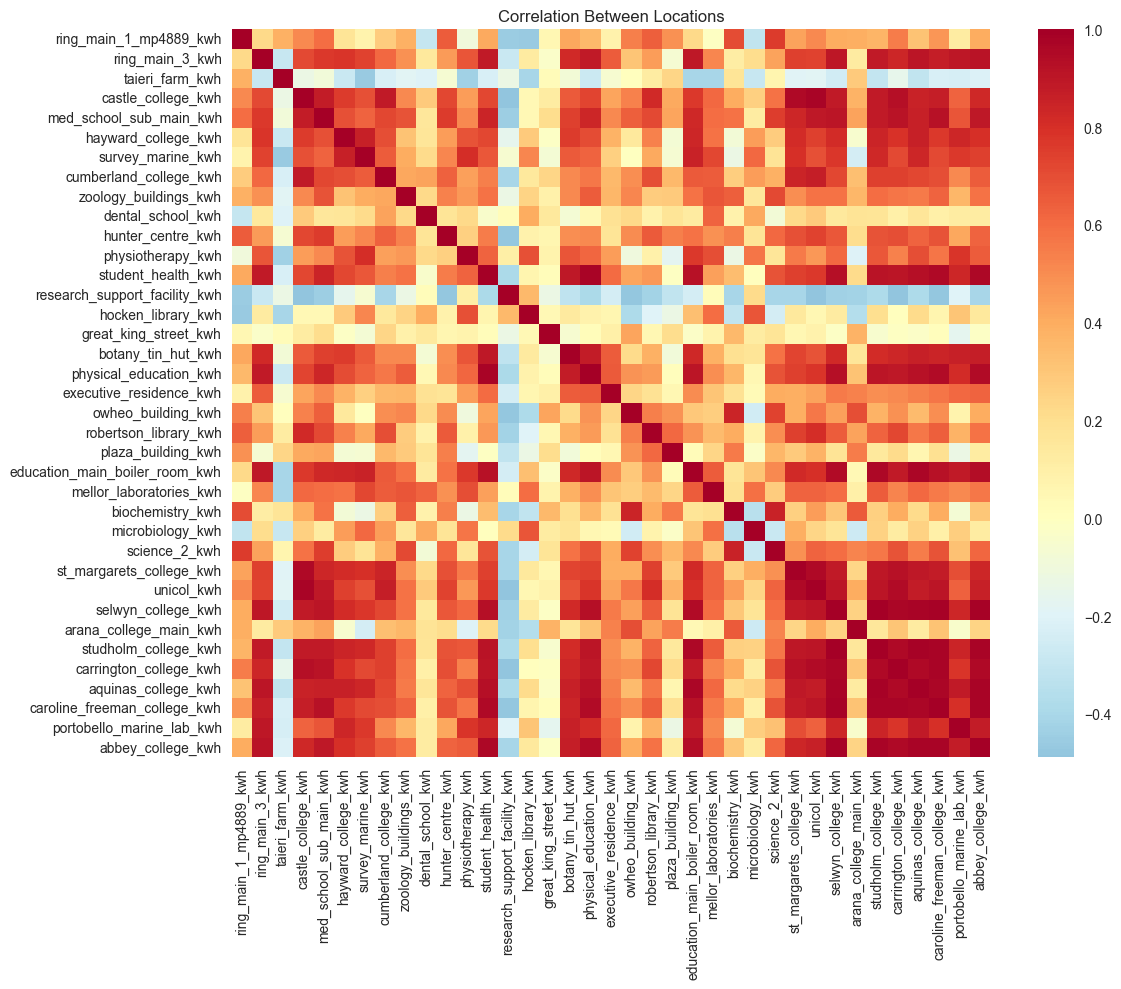

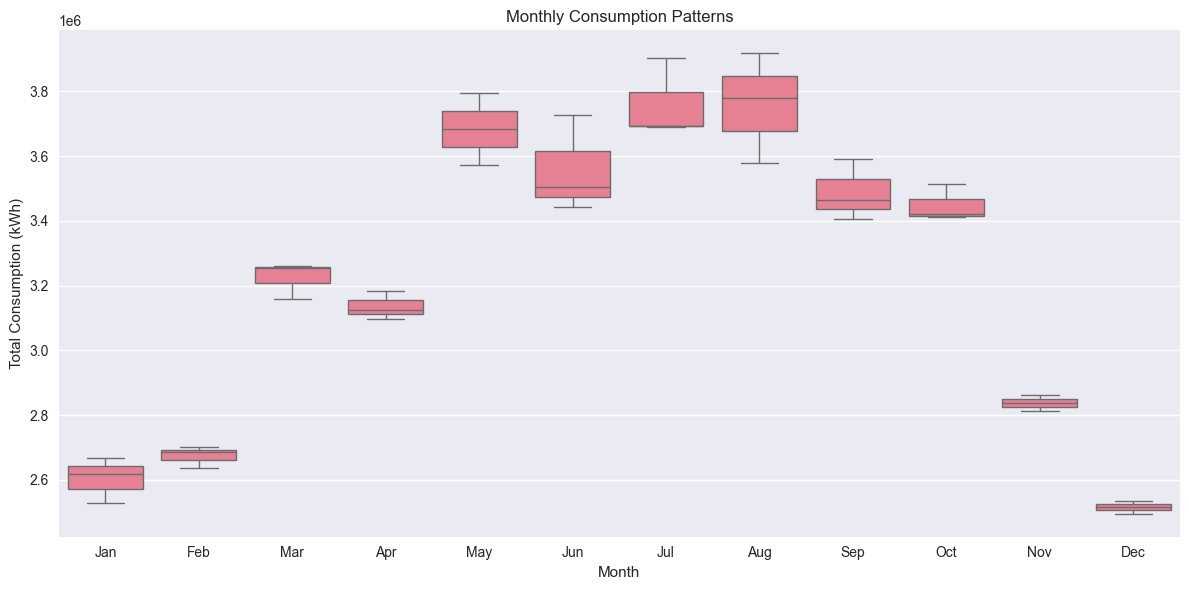


=== Potential Anomalies ===
Empty DataFrame
Columns: [date, total_consumption]
Index: []


<Figure size 1200x600 with 0 Axes>

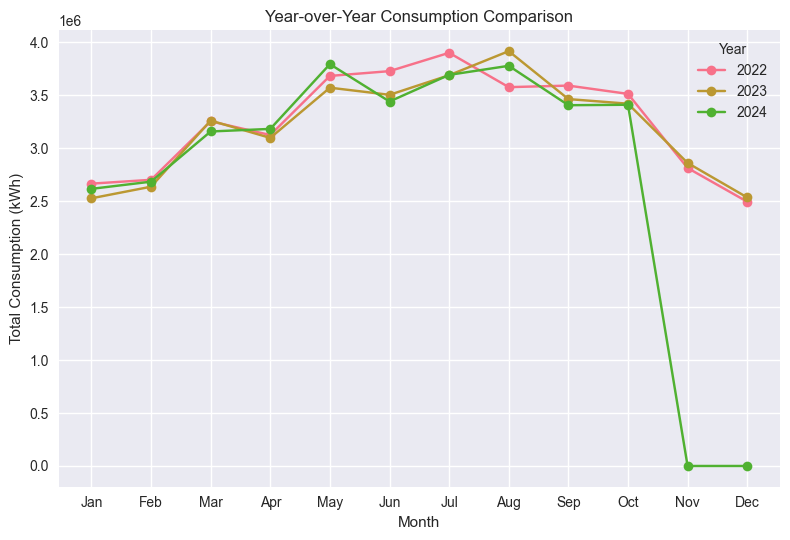

In [31]:
# Import required libraries
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Read the data
BASE_DIR = Path(os.getcwd()).parents[2]  # Get root directory
METER_PATH = BASE_DIR / "backend/data/Cleaned/Stream_DN_Electricity.csv"
df = pd.read_csv(METER_PATH)
df_base = pd.read_csv(METER_PATH)

consumption_columns = df.columns[2:] 
# Convert Month and Year columns to datetime
df['date'] = pd.to_datetime(df['meter_reading_year'].astype(str) + '-' + 
                          df['meter_reading_month'].astype(str) + '-01')

# Basic information about the dataset
#print("=== Dataset Information ===")
#print(df.info())

# Calculate total consumption by summing only consumption columns (excluding Month and Year)
df['total_consumption'] = df[consumption_columns].sum(axis=1)

# Basic statistics of total consumption
print("\n=== Total Consumption Statistics ===")
print(df['total_consumption'].describe())

# Time series plot of total consumption
plt.figure(figsize=(15, 6))
plt.plot(df['date'], df['total_consumption'], marker='o')
plt.title('Total Stream DN Electricity Consumption Over Time')
plt.xlabel('Date')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Seasonal decomposition
decomposition = seasonal_decompose(df['total_consumption'], 
                                 period=12, 
                                 model='additive')

plt.figure(figsize=(15, 12))
plt.subplot(411)
plt.plot(df['date'], decomposition.observed)
plt.title('Observed')
plt.subplot(412)
plt.plot(df['date'], decomposition.trend)
plt.title('Trend')
plt.subplot(413)
plt.plot(df['date'], decomposition.seasonal)
plt.title('Seasonal')
plt.subplot(414)
plt.plot(df['date'], decomposition.resid)
plt.title('Residual')
plt.tight_layout()
plt.show()

# Distribution of consumption by location
plt.figure(figsize=(15, 8))
df[consumption_columns].mean().sort_values(ascending=False).plot(kind='bar')
plt.title('Average Consumption by Location')
plt.xlabel('Location')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Correlation heatmap between locations
plt.figure(figsize=(12, 10))
sns.heatmap(df[consumption_columns].corr(), cmap='RdYlBu_r', center=0)
plt.title('Correlation Between Locations')
plt.tight_layout()
plt.show()

# Box plot for monthly patterns
plt.figure(figsize=(12, 6))
sns.boxplot(x='meter_reading_month', y='total_consumption', data=df)
plt.title('Monthly Consumption Patterns')
plt.xlabel('Month')
plt.ylabel('Total Consumption (kWh)')
plt.tight_layout()
plt.show()

# Check for anomalies using Z-score
z_scores = np.abs(stats.zscore(df['total_consumption']))
anomalies = df[z_scores > 3]
print("\n=== Potential Anomalies ===")
print(anomalies[['date', 'total_consumption']])

# Create pivot table with month ordering
pivot_df = df.pivot_table(index='meter_reading_month', 
                         columns='meter_reading_year',
                         values='total_consumption',
                         fill_value=0)  # Fill missing values with 0

# Create month mapping for proper ordering
month_dict = {'Jan': 1, 'Feb': 2, 'Mar': 3, 'Apr': 4, 'May': 5, 'Jun': 6,
              'Jul': 7, 'Aug': 8, 'Sep': 9, 'Oct': 10, 'Nov': 11, 'Dec': 12}

# Convert month names to numbers for sorting
pivot_df.index = pivot_df.index.map(month_dict)

# Sort by the numeric month values
pivot_df = pivot_df.sort_index()

plt.figure(figsize=(12, 6))
pivot_df.plot(marker='o')
plt.title('Year-over-Year Consumption Comparison')
plt.xlabel('Month')
plt.ylabel('Total Consumption (kWh)')

# Format x-axis ticks to show month names
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plt.xticks(range(1,13), month_names, rotation=0)

plt.legend(title='Year')
plt.tight_layout()
plt.show()



In [48]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

consumption_data = df.iloc[:, 2:].T  # Transpose and exclude month/year columns
location_names = consumption_data.index

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(consumption_data)

# Determine optimal number of clusters using elbow method
inertias = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertias.append(kmeans.inertia_)

# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method For Optimal k')
plt.show()

# Perform clustering with optimal k=4
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Calculate mean consumption for each location
mean_consumption = consumption_data.mean(axis=1)

# Create DataFrame with location and cluster information
cluster_info = pd.DataFrame({
    'Location': location_names,
    'Mean_Consumption': mean_consumption,
    'Cluster': clusters
})

# Sort by mean consumption
cluster_info = cluster_info.sort_values('Mean_Consumption', ascending=False)

# Plot clustered locations
plt.figure(figsize=(15, 8))
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']
for i in range(4):
    cluster_data = cluster_info[cluster_info['Cluster'] == i]
    plt.bar(range(len(cluster_data)), cluster_data['Mean_Consumption'], 
            label=f'Cluster {i}', color=colors[i])

plt.xticks(range(len(cluster_info)), cluster_info['Location'], rotation=90)
plt.xlabel('Location')
plt.ylabel('Mean Consumption (kWh)')
plt.title('Locations Grouped by Energy Consumption Clusters')
plt.legend()
plt.tight_layout()
plt.show()

# Print cluster analysis
print("\nCluster Analysis:")
for i in range(4):
    print(f"\nCluster {i} Locations:")
    cluster_locs = cluster_info[cluster_info['Cluster'] == i]['Location'].tolist()
    print(", ".join(cluster_locs))
    print(f"Average consumption: {cluster_info[cluster_info['Cluster'] == i]['Mean_Consumption'].mean():.2f} kWh")

TypeError: float() argument must be a string or a real number, not 'Timestamp'

In [ ]:

z    'Location': consumption_cols,
    'Mean_Consumption': mean_consumption.values,
    'Cluster': kmeans.labels_
})

In [45]:
kmeans.labels_

array([0, 2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 0, 0, 0, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [47]:
consumption_cols


Index(['ring_main_1_mp4889_kwh', 'ring_main_3_kwh', 'taieri_farm_kwh',
       'castle_college_kwh', 'med_school_sub_main_kwh', 'hayward_college_kwh',
       'survey_marine_kwh', 'cumberland_college_kwh', 'zoology_buildings_kwh',
       'dental_school_kwh', 'hunter_centre_kwh', 'physiotherapy_kwh',
       'student_health_kwh', 'research_support_facility_kwh',
       'hocken_library_kwh', 'great_king_street_kwh', 'botany_tin_hut_kwh',
       'physical_education_kwh', 'executive_residence_kwh',
       'owheo_building_kwh', 'robertson_library_kwh', 'plaza_building_kwh',
       'education_main_boiler_room_kwh', 'mellor_laboratories_kwh',
       'biochemistry_kwh', 'microbiology_kwh', 'science_2_kwh',
       'st_margarets_college_kwh', 'unicol_kwh', 'selwyn_college_kwh',
       'arana_college_main_kwh', 'studholm_college_kwh',
       'carrington_college_kwh', 'aquinas_college_kwh',
       'caroline_freeman_college_kwh', 'portobello_marine_lab_kwh',
       'abbey_college_kwh'],
      dtype='o